# Introduction

This notebook shows an example of relaxing the LiFePO4 crystal.

If you are running this notebook from Google Colab, uncomment the next code box to install m3gnet first.

In [ ]:
# !pip install m3gnet

In [ ]:
import warnings

import numpy as np
from pymatgen.ext.matproj import MPRester
from pymatgen.util.coord import pbc_diff

from m3gnet.models import Relaxer

for category in (UserWarning, DeprecationWarning):
    warnings.filterwarnings("ignore", category=category, module="tensorflow")

In [ ]:
mpr = MPRester()
lfp = mpr.get_structure_by_material_id("mp-19017")  # This is LiFePO4.

lfp_strained = lfp.copy()  # We create a copy.
# Create a random strain between -5% and 5% for each direction
strains = np.random.uniform(low=-0.05, high=0.05, size=3)
lfp_strained.apply_strain(strains)
# In addition to the lattice strains, we also perturb the atoms by a distance of 0.1 angstrom.
lfp_strained.perturb(0.1)

In [ ]:
relaxer = Relaxer()
relax_results: dict
%time relax_results = relaxer.relax(lfp_strained)
relaxed_struct = relax_results["final_structure"]

2022-08-16 15:10:14.833037: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


CPU times: user 13.1 s, sys: 2.22 s, total: 15.3 s
Wall time: 9.48 s


Note that the relaxation only took < 20s.

The relaxation using the M3GNet universal IAP has brought the lattice parameters much closer to the original DFT ones and the coordinates are also within $10^{-3}$ of the original fractional coordinates.

In [ ]:
print(f"Original lattice parameters are {[round(x, 3) for x in lfp.lattice.abc]}")
print(f"Strained lattice parameters are {[round(x, 3) for x in lfp_strained.lattice.abc]}")
print(f"Relaxed lattice parameters are {[round(x, 3) for x in relaxed_struct.lattice.abc]}")

Original lattice parameters are [4.746, 10.444, 6.09]
Strained lattice parameters are [4.655, 10.116, 6.169]
Relaxed lattice parameters are [4.749, 10.447, 6.105]


In [ ]:
lfp_strained.frac_coords

array([[9.95585866e-01, 5.09294457e-04, 9.84189370e-01],
       [5.20894009e-01, 5.01713435e-01, 9.97474321e-01],
       [5.04853356e-01, 4.91625924e-01, 5.07732446e-01],
       [1.96716573e-02, 9.98423822e-01, 4.93991898e-01],
       [4.66972193e-01, 2.26221410e-01, 7.56598929e-01],
       [1.75367824e-02, 7.14677040e-01, 7.64243428e-01],
       [9.74532693e-01, 2.74308700e-01, 2.60366885e-01],
       [5.05152825e-01, 7.85728905e-01, 2.50998223e-01],
       [4.11383909e-01, 8.64375884e-02, 2.42736461e-01],
       [9.22660218e-01, 4.05067751e-01, 7.34201221e-01],
       [6.64774830e-02, 5.88037118e-01, 2.49265519e-01],
       [5.62188874e-01, 9.05333524e-01, 7.43938118e-01],
       [7.51256294e-01, 1.04193044e-01, 2.42070362e-01],
       [2.47872494e-01, 4.03677933e-01, 7.65556546e-01],
       [7.64247175e-01, 6.05980547e-01, 2.46644955e-01],
       [2.37052521e-01, 9.01273281e-01, 7.49090937e-01],
       [1.98641403e-01, 4.49672882e-01, 2.58717668e-01],
       [7.12504542e-01, 4.95576

In [ ]:
strained_to_orig_frac_coords_mean_diff = abs(pbc_diff(lfp_strained.frac_coords, lfp.frac_coords)).mean()

print(
    "mean diff in frac. coords. between strained and original "
    f"LFP structure: {strained_to_orig_frac_coords_mean_diff:.3}"
)

mean diff in frac. coords. between strained and original LFP structure: 0.00798


In [ ]:
orig_to_m3gnet_frac_coords_mean_diff = abs(pbc_diff(lfp.frac_coords, relaxed_struct.frac_coords)).mean()

print(
    "mean diff in frac. coords. between original and M3GNet-relaxed "
    f"LFP structure: {orig_to_m3gnet_frac_coords_mean_diff:.3}"
)

mean diff in frac. coords. between original and M3GNet-relaxed LFP structure: 0.0026


In [ ]:
mean_pbc_diff_ratio = strained_to_orig_frac_coords_mean_diff / orig_to_m3gnet_frac_coords_mean_diff

print(
    f"M3GNet reduces the mean difference in frac. coords. from the strained "
    f"to the original structure by a factor of: {mean_pbc_diff_ratio:.3}"
)

M3GNet reduces the mean difference in frac. coords. from the strained to the original structure by a factor of: 3.07


# Phonon Band Structure and DOS

The M3GNet IAP can also be used to compute the lattice vibrations in a super cell.

In [ ]:
from ase.phonons import Phonons
from pymatgen.io.ase import AseAtomsAdaptor

from m3gnet.models import M3GNet, M3GNetCalculator, Potential

mp_129 = mpr.get_structure_by_material_id(mp_id := "mp-129")

# Setup crystal and EMT calculator
atoms = AseAtomsAdaptor().get_atoms(mp_129)

potential = Potential(M3GNet.load())

calculator = M3GNetCalculator(potential=potential, stress_weight=0.01)

# Phonon calculator
N = 7
supercell = (N, N, N)
ph = Phonons(atoms, calculator, supercell=supercell, delta=0.05)
ph.run()

# Read forces and assemble the dynamical matrix
ph.read(acoustic=True)
ph.clean()

path = atoms.cell.bandpath("GHPGN", npoints=100)
bs = ph.get_band_structure(path)

dos = ph.get_dos(kpts=(20, 20, 20)).sample_grid(npts=100, width=1e-3)

WARNING, 1 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 4.480e-09*i)
WARNING, 1 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 4.480e-09*i)


Text(0.5, 1.02, 'Phonon band structure and DOS of LiFePO4 Mo1 (mp-129) with (7, 7, 7) supercell')

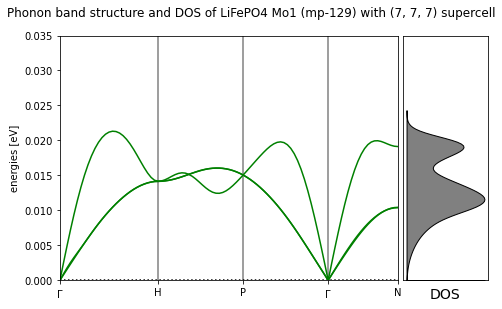

In [ ]:
# Plot the band structure and DOS:
import matplotlib.pyplot as plt

plt.rc("figure", dpi=150)

fig = plt.figure(1, figsize=(7, 4))
bs_ax = fig.add_axes([0.12, 0.07, 0.67, 0.85])

emax = 0.035
bs.plot(ax=bs_ax, emin=0.0, emax=emax)

dos_ax = fig.add_axes([0.8, 0.07, 0.17, 0.85])
dos_ax.fill_between(dos.get_weights(), dos.get_energies(), y2=0, color="grey", edgecolor="black", lw=1)

dos_ax.set_ylim(0, emax)
dos_ax.set_yticks([])
dos_ax.set_xticks([])
dos_ax.set_xlabel("DOS", fontsize=14)

fig.suptitle(
    f"Phonon band structure and DOS of LiFePO4 {mp_129.formula} ({mp_id}) with {supercell} supercell",
    fontsize=12,
    y=1.02,
)